# Initialize the Database

In [1]:
# Let's start by initializing the database
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import numpy as np

nusc = NuScenes(version='v0.1', dataroot='data/nuscenes', verbose=True)

Loading NuScenes tables for version v0.1 ...
23 category,
8 attribute,
5 visibility,
6975 instance,
12 sensor,
1200 calibrated_sensor,
304715 ego_pose,
12 log,
100 scene,
3977 sample,
304715 sample_data,
99952 sample_annotation,
12 map,
Done loading in 10.4 seconds.
Reverse indexing ...
Done reverse indexing in 3.0 seconds.


Categories that are annotated

In [2]:
# The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary. 
# For example the first record of the category table is stored at

#nusc.category[0]['name']

#these are the categories available
cat = []
for i in range(len(nusc.category)):
    print(nusc.category[i]['name'])
    cat.append(nusc.category[i]['name'])



human.pedestrian.adult
human.pedestrian.child
human.pedestrian.wheelchair
human.pedestrian.stroller
human.pedestrian.personal_mobility
human.pedestrian.police_officer
human.pedestrian.construction_worker
animal
vehicle.car
vehicle.motorcycle
vehicle.bicycle
vehicle.bus.bendy
vehicle.bus.rigid
vehicle.truck
vehicle.construction
vehicle.emergency.ambulance
vehicle.emergency.police
vehicle.trailer
movable_object.barrier
movable_object.trafficcone
movable_object.pushable_pullable
movable_object.debris
static_object.bicycle_rack


# classes that we are detecting :

We merge adult, child, police officer, construction worker into a single class called pedestrian
We are detecting: 
- pedestrian
- car 
- bicycle

In [3]:
classes = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker','vehicle.car','vehicle.bicycle']
 

In [4]:
print('Total number of samples')
print(len(nusc.sample))

print('Total number of images')
print(len(nusc.sample*6)) #6 different cameras

Total number of samples
3977
Total number of images
23862


# Functions

Defined the following function:

- get_sample_data (edit of nutonomy's original nusc.get_sample_data)
        
        input:(nusc, sample_data_token)
        output:path to the data, lists of 3d bounding boxes in the image (in camera coordinates), 
        annotation token of annotations in the image, intrinsic matrix of the camera)
        

- threeD_to_2D
         
        input: (box (camera coordinates),intrinsic matrix))
        output : corners of the 2d bounding box in image plane

- all_3d_to_2d(boxes,anns,intrinsic)

        input : boxes in camera coordinates, list of annotation tokens of annotations in the image, 
        intrinsic matrix
        output: x_min,x_max,y_min,y_max,width,height of the 2D boundings boxes of objects that are
        more than 40% visible in panoramic view of all cameras, also ensures that the center of the 
        bounding boxes falls inside the image

- extract_bounding_box(i):
        
        input: sample number
        output: min x, max x, min y max y, width and height of bounding box in image coordinates 
        2d bounding box of objects which are 40% visible in panoramic view of all cameras and center 
        falls witin the image



In [5]:
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import quaternion_slerp, box_in_image, BoxVisibility
import numpy as np
def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token.
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)

    return data_path, box_list, ann_list, cam_intrinsic

In [6]:
def threeD_2_twoD(boxsy,intrinsic):
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
    

    
    return min_x,max_x,min_y,max_y

#get corners from boxes
#print(boxes)
#print(intrinsic_matrix.shape)
#box = boxes[0]

def all_3d_to_2d(boxes,anns,intrinsic):
    x_min=[]
    x_max=[]
    y_min=[]
    y_max =[]
    width=[]
    height=[]
    
   
    for j in range(len(boxes)):
        box=boxes[j]
        
        if box.name in classes:
        
            #print(box)
            
            visibility = nusc.get('sample_annotation', '%s' %anns[j])['visibility_token']
            visibility = int(visibility)
            
            #print("YOLO")
            #print(visibility)
            #print(type(visibility))
            
            if visibility > 1: #more than 40% visible in the panoramic view of the the cameras

                    
                center = box.center

                center = np.dot(intrinsic,center)
                center_point = center/(center[2])
                
                
                #print("BOO")
                min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic)
                if center_point[0] <-100 or center_point[0] > 1700 or center_point[1] <-100 or center_point[1] >1000:
                    #if center of bounding box is outside of the image, do not annotate
                    pass
                
                else:
                    
                    w = max_x - min_x
                    h = max_y - min_y
        
        
                    x_min.append(min_x)
                    x_max.append(max_x)
                    y_min.append(min_y)
                    y_max.append(max_y)
                    width.append(w)
                    height.append(h)

            else:
                pass

    return x_min,x_max,y_min,y_max,width,height

In [7]:
def extract_bounding_box(i,camera_name):
    
    '''
    input sample number
    outputs min x, max x, min y max y, width and height of bounding box in image coordinates
    2d bounding box
    options for camera name : CAM_FRONT, CAM_FRONT_RIGHT, CAM_FRONT_LEFT, CAM_BACK, CAM_BACK_RIGHT,CAM_BACK_LEFT
    '''
    nusc.sample[i]
    
    front_token = nusc.sample[i]['data']['%s' %camera_name]
    #print(front_token)
    #sample_data = nusc.get('sample_data', '%s' %front_token)
    print(front_token)
    path, boxes, anns, intrinsic_matrix = get_sample_data(nusc,'%s' %front_token)
    x_min, x_max,y_min,y_max,width,height = all_3d_to_2d(boxes,anns, intrinsic_matrix)
    
    return x_min, x_max, y_min, y_max, width, height, path, boxes , intrinsic_matrix
    #return(boxes)
    

In [8]:
sample_number = 888
camera = 'CAM_FRONT'

x_min, x_max,y_min,y_max,width,height, path, boxes, intrinsic_matrix = extract_bounding_box(sample_number, '%s' %camera) #get bounding box info for sample 3345


232a7b7910334365b6defecc264fcbbd


In [9]:
'''
Example of image path

'''
print(path)

data/nuscenes/samples/CAM_FRONT/n015-2018-07-18-11-18-34+0800__CAM_FRONT__1531884264162460.jpg


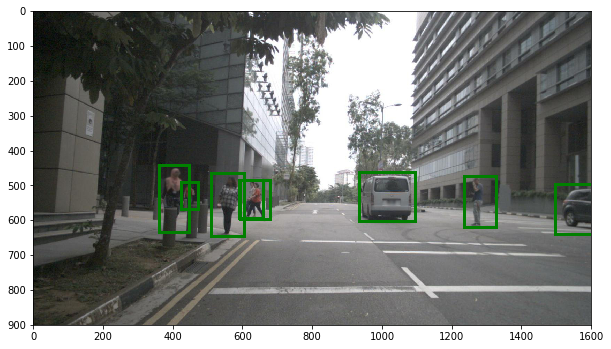

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = np.array(Image.open('/Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/%s' %path), dtype=np.uint8)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
# Create figure and axes


# Display the image
ax.imshow(im)
#

#print(x)
#print(y)
#print(width)
#print(height)
#print(center_point[0])
#print(center_point[1])

#width = max_x-min_x
#height = max_y-min_y
#for i in range(len(perspective_x)):
#ax.plot(center_point[0], center_point[1], marker ='o', color='b', markersize =30)
#ax.plot(perspective_x[i], perspective_y[i], marker ='o', color='b', markersize =10)
#ax.plot(r2c2[0], r2c2[1], marker ='o', color='b', markersize =10)
#ax.plot(min_x, min_y, marker ='o', color='b', markersize =10)
#ax.plot(max_x, max_y, marker ='o', color='b', markersize =10)

for i in range(len(x_min)):
    rect = patches.Rectangle((x_min[i],y_min[i]),width[i],height[i],linewidth=3,edgecolor='green',facecolor='none')
#ax.plot(k3[0], k3[1], marker ='o', color='b', markersize =10)
#ax.plot(k4[0], k4[1], marker ='o', color='b', markersize =10)
#ax.plot(k5[0], k5[1], marker ='o', color='b', markersize =10)
#ax.plot(k6[0], k6[1], marker ='o', color='b', markersize =10)
#ax.plot(k7[0], k7[1], marker ='o', color='b', markersize =10)
#ax.plot(k8[0], k8[1], marker ='o', color='b', markersize =10)
    
#rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='blue',facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)
plt.savefig('foo.jpeg')
plt.show()

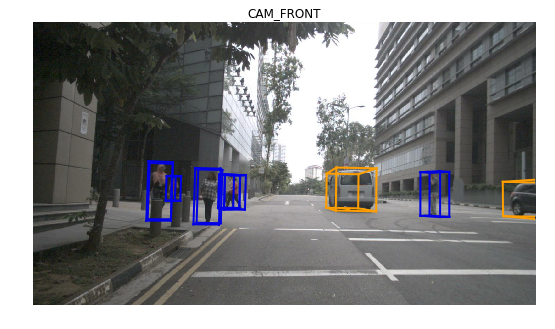

In [11]:
#3d render with original bounding boxes
my_sample = nusc.sample[sample_number]
nusc.render_sample_data(my_sample['data']['%s' %camera])